In [10]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import netCDF4
import sys
import point_run_tools as prt
from itertools import combinations
import subprocess
import warnings
import math
cwd = os.getcwd()
print(os.getcwd())
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16}) 
c_loc = '../../' # change if cardaom C file is moved

/Users/mworden/Downloads/CARDAMOM_2.1-3.6c-main/PYTHON/Point_Run_Tutorial


## Compile CARDAMOM C files into executables (compile errors: 0 required to continue)

In [2]:
exitcode_compile = subprocess.run(['./../../BASH/CARDAMOM_COMPILE.sh'], capture_output=True)
print(" ".join(exitcode_compile.args),"\n")
print("CARDAMOM compile errors:",exitcode_compile.returncode,"\n","".join(exitcode_compile.stderr.decode("utf-8")),"\n")

./../../BASH/CARDAMOM_COMPILE.sh 

CARDAMOM compile errors: 0 
  



## Choose Site File; Check DALEC Drivers and Assimilated Data

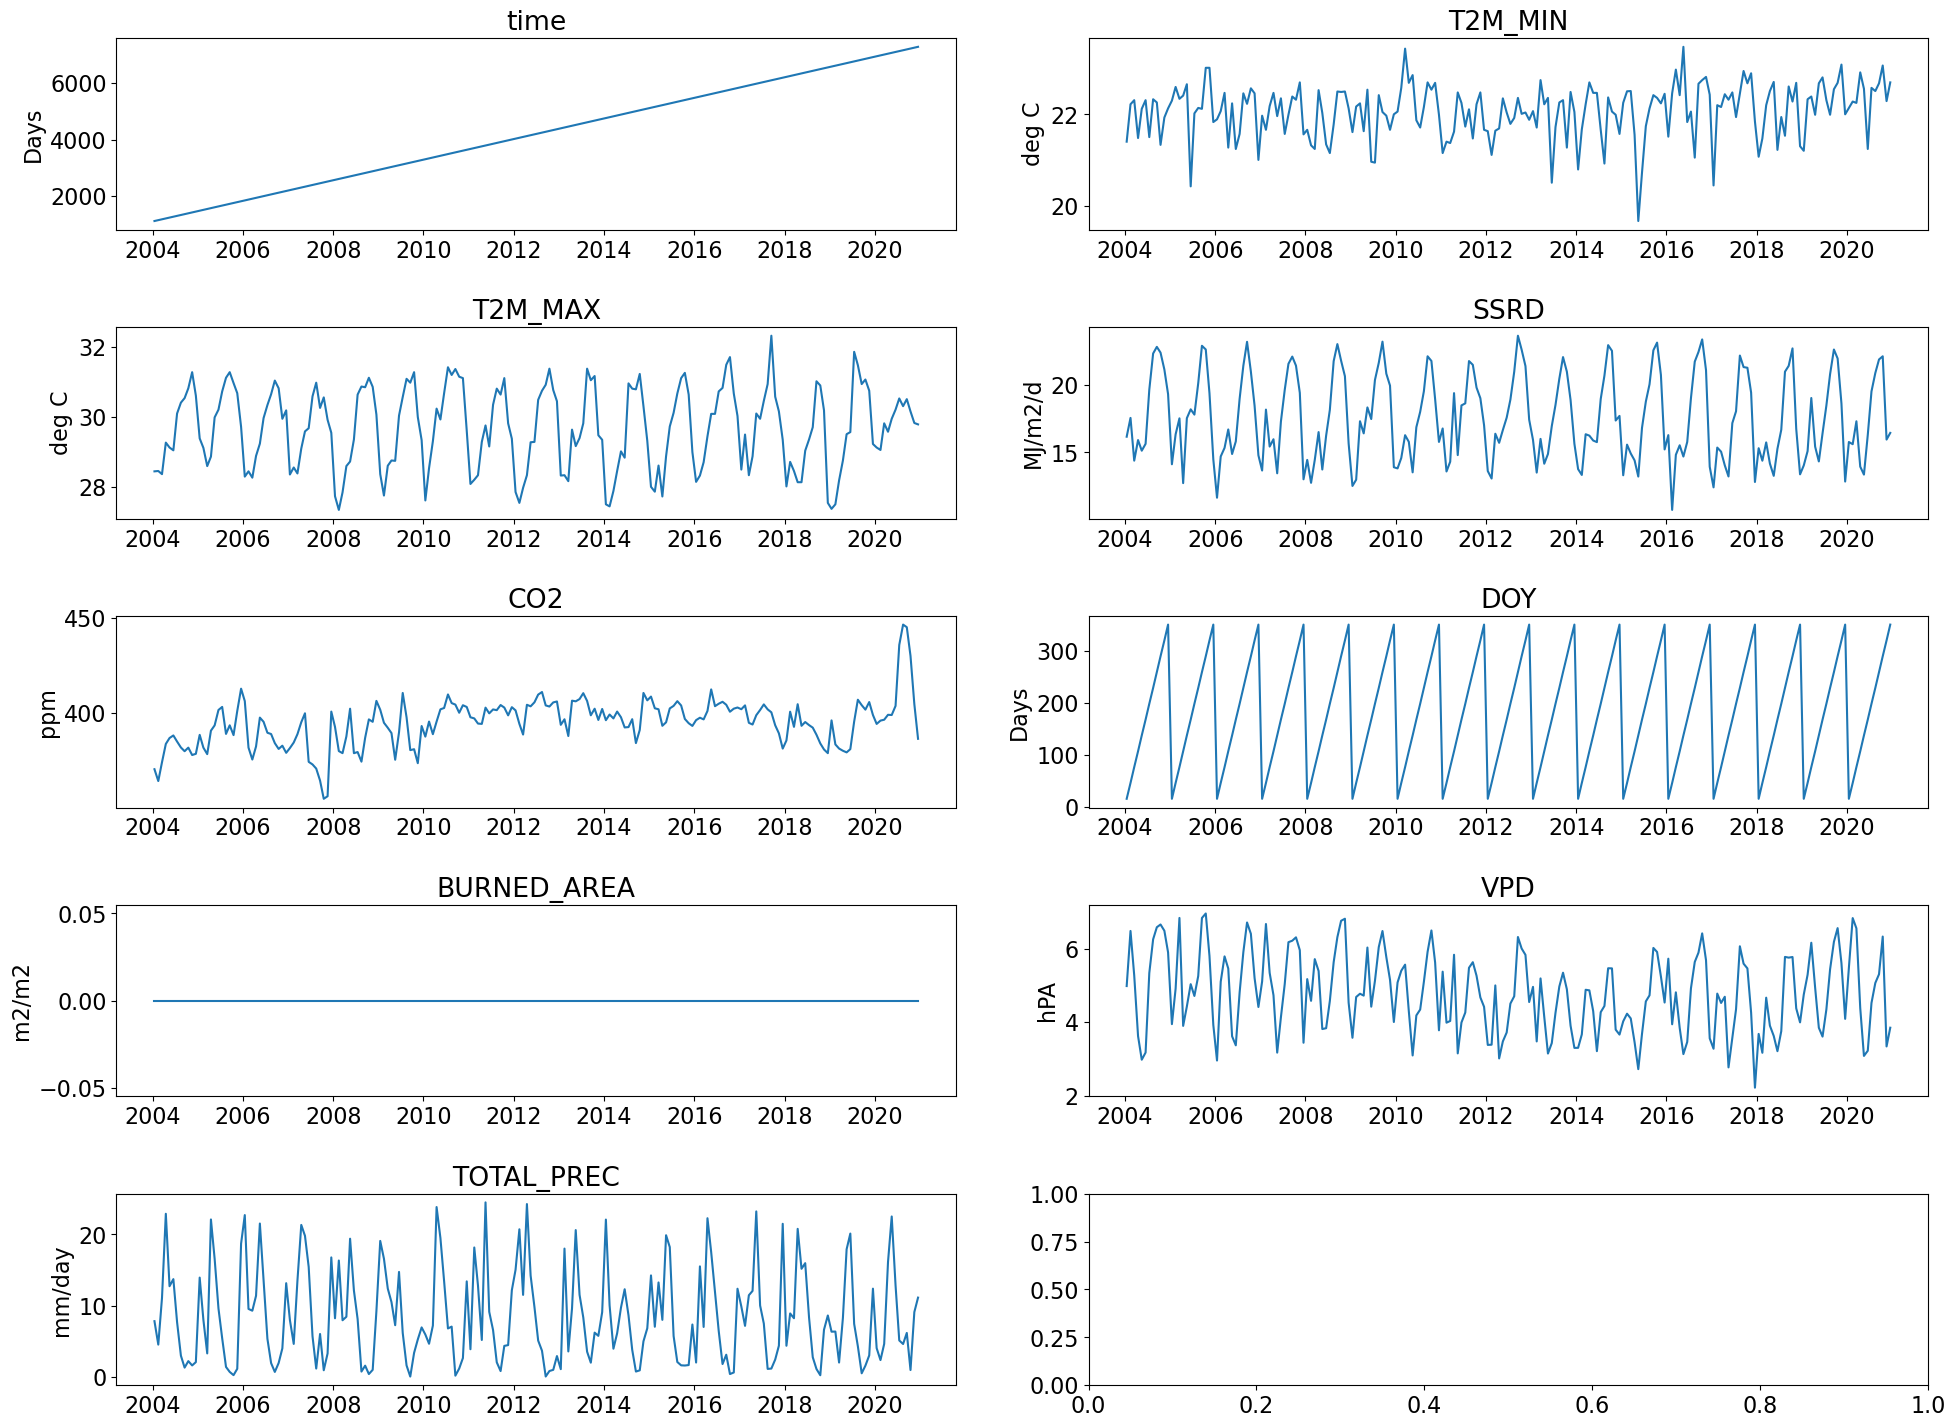

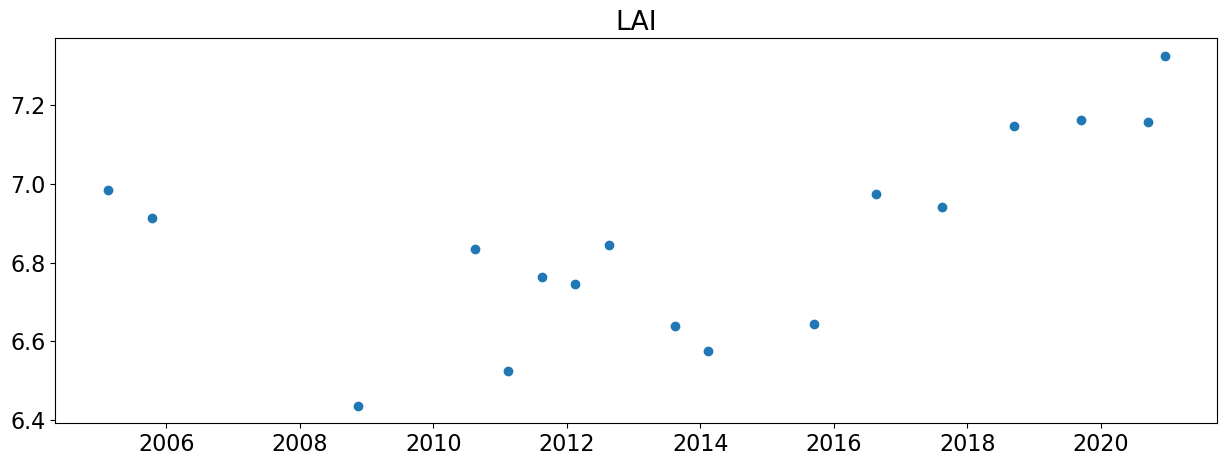

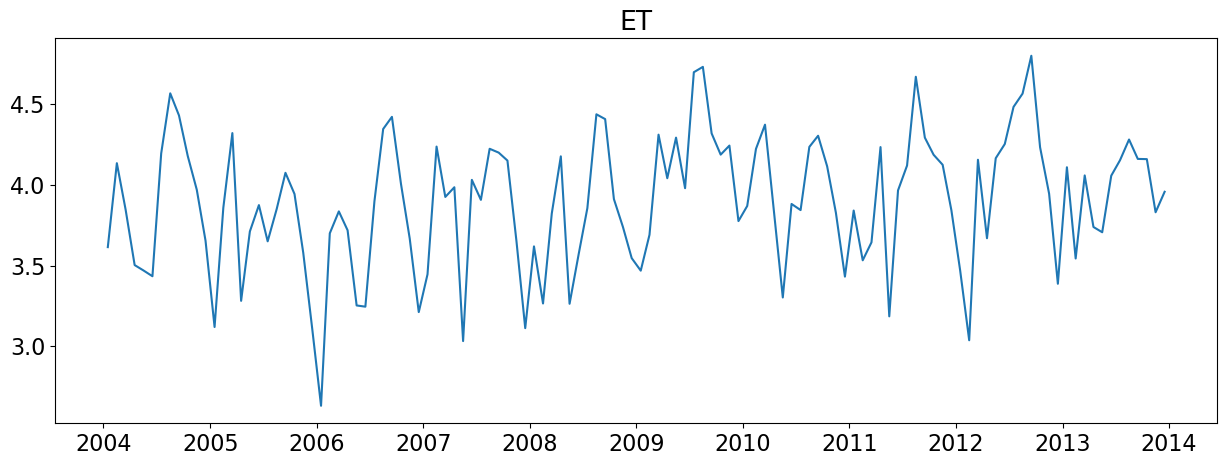

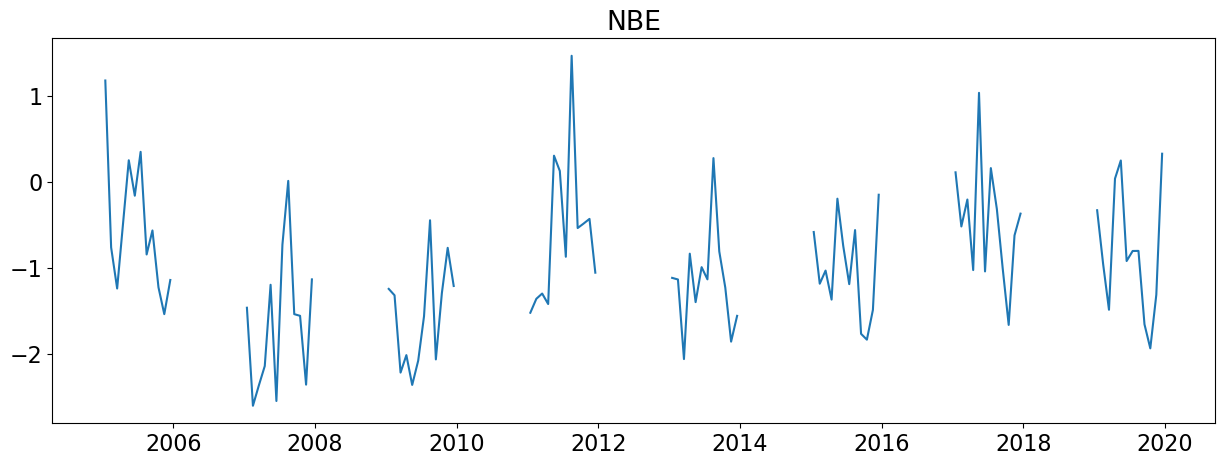

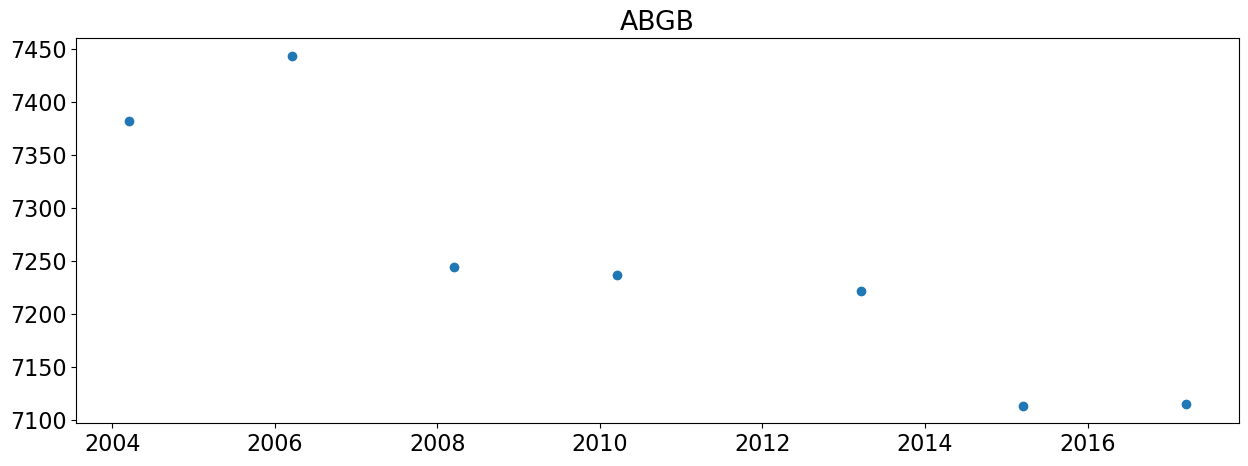

In [3]:
#model input file (change input file for different point)
cbffile = "Guyaflux.nc.cbf"
cbf = netCDF4.Dataset(cbffile,'r')

dates = prt.get_dates(cbf['time'][:])

#Check Model Drivers (Requires a value at every timestep even if 0)
drivers= ['time','T2M_MIN','T2M_MAX','SSRD','CO2','DOY','BURNED_AREA','VPD','TOTAL_PREC',"SNOWFALL"]
f, axs = plt.subplots(5,2,figsize=(20,15))
f.tight_layout(pad=2.5)
for i in range(1,len(drivers)+1):
    if( drivers[i-1] in cbf.variables.keys()):
        plt.subplot(5,2,i)
        plt.title(drivers[i-1])
        plt.plot(dates,cbf[drivers[i-1]][:])
        plt.ylabel(cbf[drivers[i-1]].units)
        
#Check Assimilated data (Missing values allowed)
assim = prt.assim_data_info(c_loc,int(cbf["ID"][:]))
for i in range(0,len(assim)):
    if( assim[i] in cbf.variables.keys()):
        assim_data = prt.rm99(cbf[assim[i]][:])
        if(np.sum(~np.isnan(assim_data)) < len(assim_data)/10):
            plt.figure(figsize = (15,5))
            plt.title(assim[i])
            plt.scatter(dates,assim_data)
        elif(np.sum(~np.isnan(assim_data)) ):
            plt.figure(figsize = (15,5))
            plt.title(assim[i])
            plt.plot(dates,assim_data)

plt.show()

## Run Model Data Fusion (Assimilation Runs)

In [4]:
#setup chains to be run - for DEMCMC only need 1 chain for MHMCMC need 4 chains at least
chains = []
numchains = 1
for a in range(1,numchains+1):
    cmd = [c_loc + "C/projects/CARDAMOM_MDF/CARDAMOM_MDF.exe",cbffile,"chain_"+str(a)+".cbr" ]
    print(" ".join(cmd),"\n")
    chains+=[cmd]

../../C/projects/CARDAMOM_MDF/CARDAMOM_MDF.exe Guyaflux.nc.cbf chain_1.cbr 



In [5]:
#Choose number of chains to run in parrallel (check how many cores/threads avaiable on computer)
max_processes = 4
if max_processes > numchains:
    max_processes = numchains
    # Don't waste computation

processes = set()
for name in chains:
    a = processes.add(subprocess.Popen(name))
    if len(processes) >= max_processes:
        os.wait()
        processes.difference_update([p for p in processes if p.poll() is not None])
print("assimilation complete")        

assimilation complete


dyld[14681]: Library not loaded: @rpath/libnetcdf.19.dylib
  Referenced from: <1A6965D5-FE6F-3293-8EC6-126107E281CF> /Users/mworden/Downloads/CARDAMOM_2.1-3.6c-main/C/projects/CARDAMOM_MDF/CARDAMOM_MDF.exe
  Reason: tried: '/System/Volumes/Preboot/Cryptexes/OS@rpath/libnetcdf.19.dylib' (no such file), '/usr/local/lib/libnetcdf.19.dylib' (no such file), '/usr/lib/libnetcdf.19.dylib' (no such file, not in dyld cache)


## Check posterior paramater distributions (CBR files) for convergence

Within-walker convergence: the distribution of parameter values within the first and second half of samples for a given walker (exclude burn in)

Across-walker convergence: the distribution of parameter values across all 200 walkers (exclude burn in)

Across Walker Convergence % Gelman Rubin less then 1.2: 84.091%
Across Walker Mean Gelman Rubin Convergence : 1.114


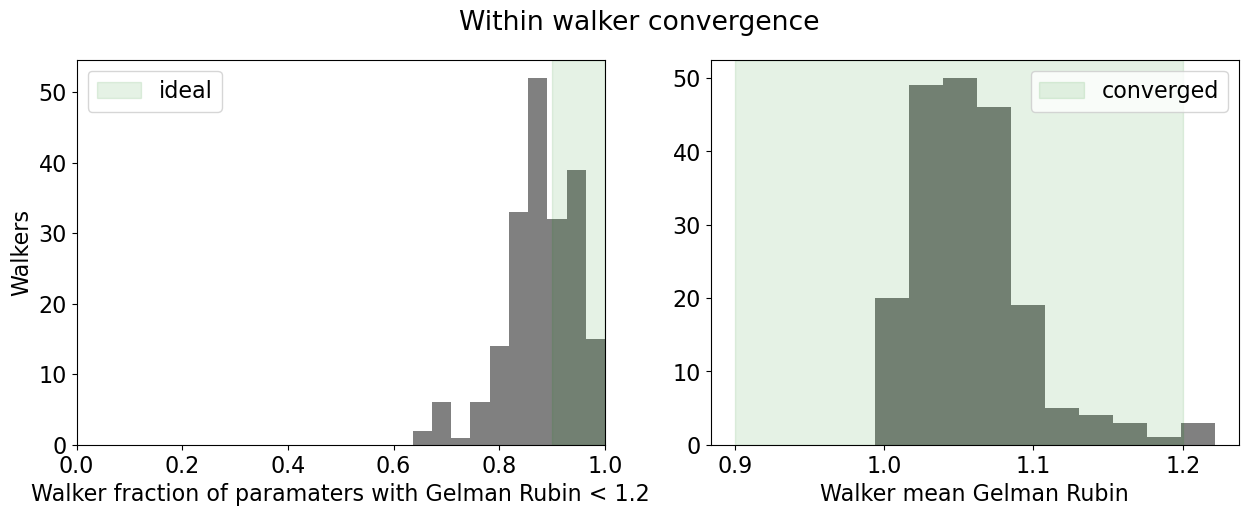

In [6]:
L = [f for f in os.listdir() if f.endswith('.cbr')]
numpars = prt.numpars(c_loc,int(cbf["ID"][:]))
fracs,meangrs,Across_walkersgr  =  prt.DEMCMC_conv(L,numpars)
    
  
f, axs = plt.subplots(1,2,figsize=(15,5))
plt.suptitle("Within walker convergence")
plt.subplot(1,2,1)
plt.hist(fracs,color = 'grey')
plt.xlabel('Walker fraction of paramaters with Gelman Rubin < 1.2')
plt.axvspan(.9, 1, alpha=0.1, color='green',label ='ideal')
plt.legend()
plt.ylabel('Walkers')
plt.xlim([0,1])

plt.subplot(1,2,2)
plt.hist(meangrs,color = 'grey')
plt.xlabel('Walker mean Gelman Rubin')
plt.axvspan(.9, 1.2, alpha=0.1, color='green',label ='converged')
plt.legend()

acfracgr = len(Across_walkersgr[Across_walkersgr<1.2])/len(Across_walkersgr)
acmeangr = np.mean(Across_walkersgr)
print("Across Walker Convergence % Gelman Rubin less then 1.2: " + str(round(acfracgr*100,3)) + "%")
print("Across Walker Mean Gelman Rubin Convergence : " + str(round(acmeangr,3)))
plt.show()

# Plot posterior paramater distribution

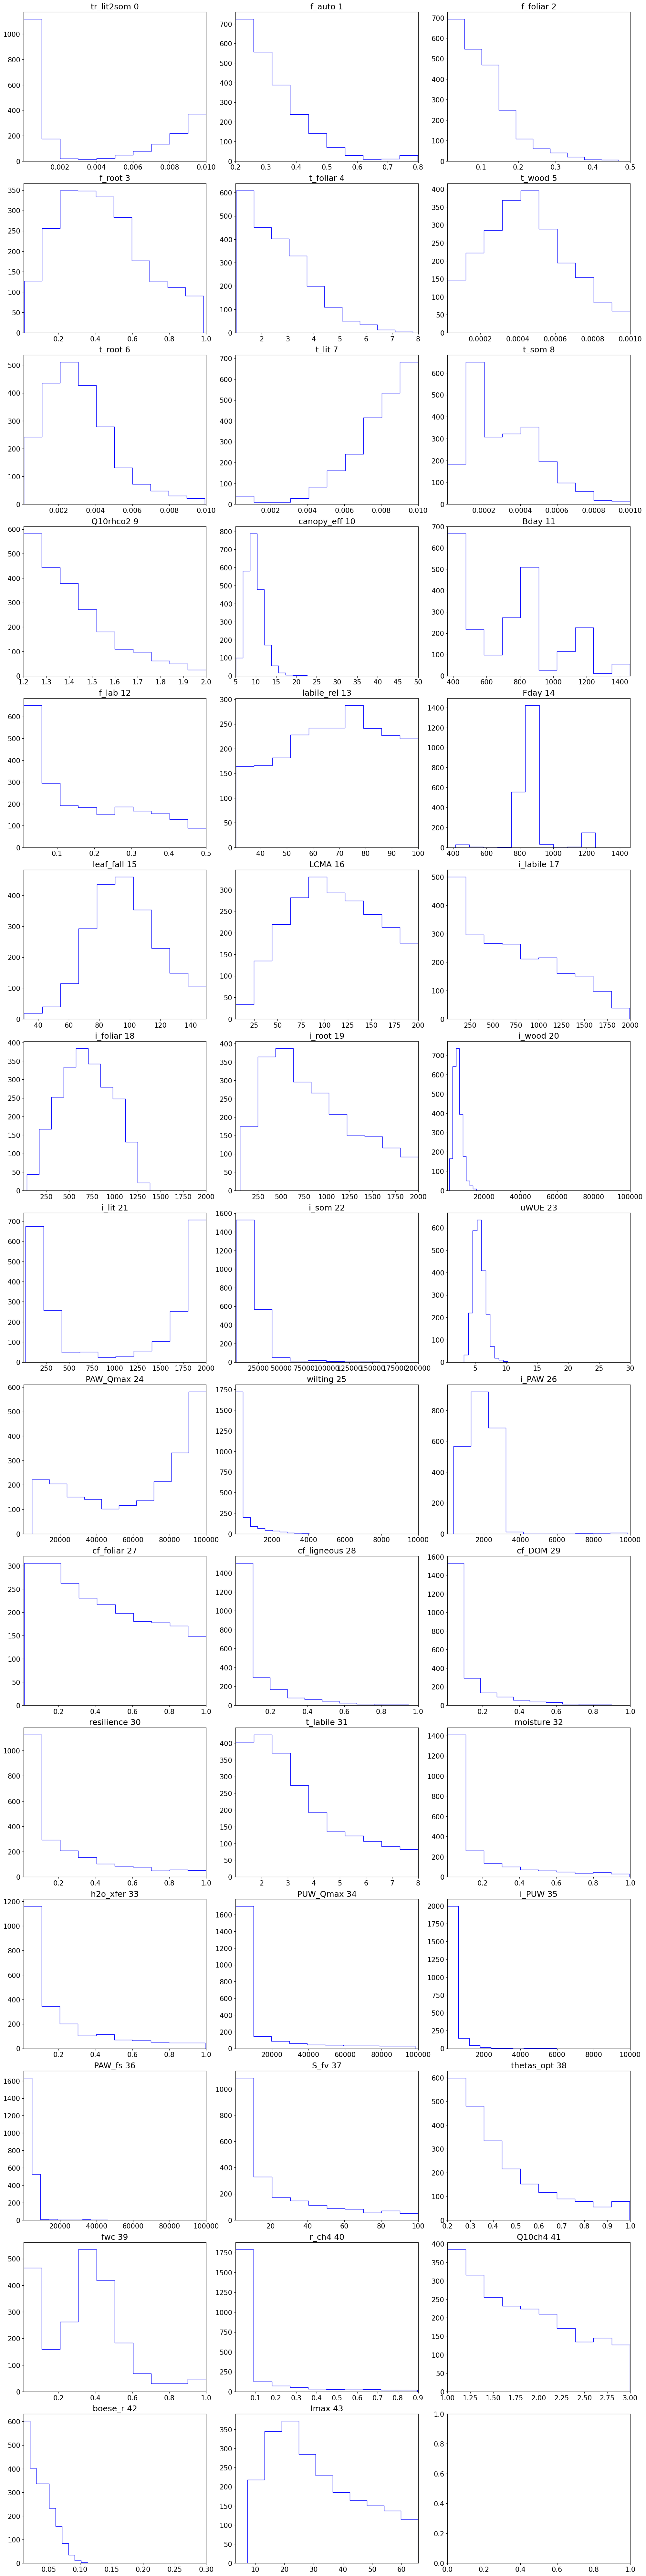

In [7]:
parinfo = prt.cbr_info(c_loc, int(cbf["ID"][:]))
cbrfile = L[0]
cbr = prt.read_cbr_file(cbrfile,numpars)

plt.rcParams.update({'font.size': 15})
f, axs = plt.subplots(int(numpars/3)+1,3,figsize=(20,80))
f.tight_layout(pad=1.5)
for i,a in enumerate(parinfo.keys()):
    plt.subplot(int(numpars/3)+1,3,i+1)
    plt.title(a + " " + str(i))
    plt.hist(cbr[:,parinfo[a][0]],color = 'blue',histtype=u'step')
    plt.xlim(parinfo[a][1],parinfo[a][2])#This line set the x axis to the prior distributino range remove for closer detail on distribution
 


## Run DALEC with posterior paramater distributions 

In [5]:
exitcode_DALEC_run = subprocess.run([c_loc+"C/projects/CARDAMOM_GENERAL/CARDAMOM_RUN_MODEL.exe", 
                              cbffile,
                              cbrfile] , capture_output=True)

print(" ".join(exitcode_DALEC_run.args),"\n")
print("run errors:",exitcode_DALEC_run.returncode,"\n","".join(exitcode_DALEC_run.stderr.decode("utf-8")))



../../C/projects/CARDAMOM_GENERAL/CARDAMOM_RUN_MODEL.exe Niwot_Ridge.cbf.nc nwr.cbr 

run errors: 2 
 


## Plot DALEC Fluxes from optimal parmaters

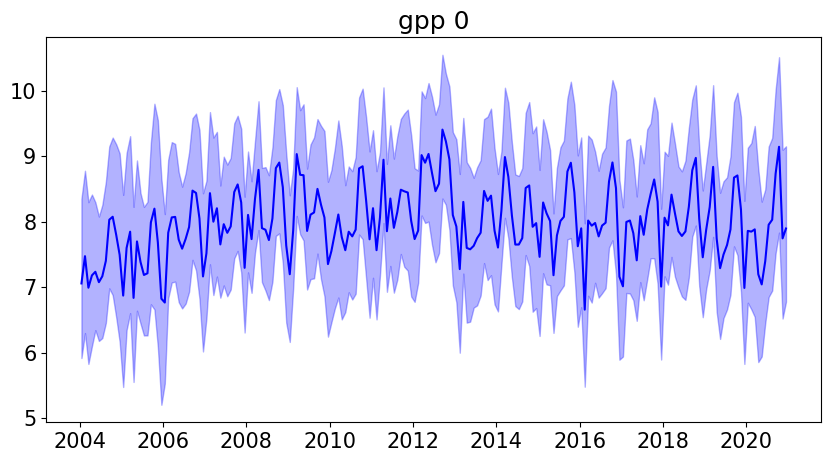

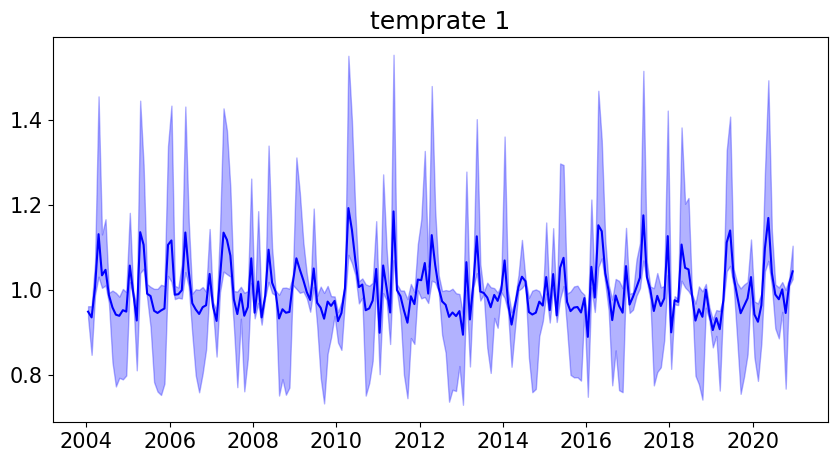

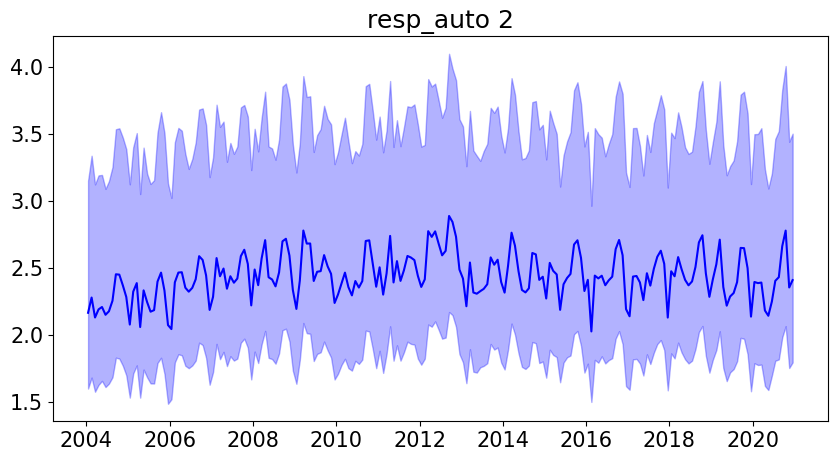

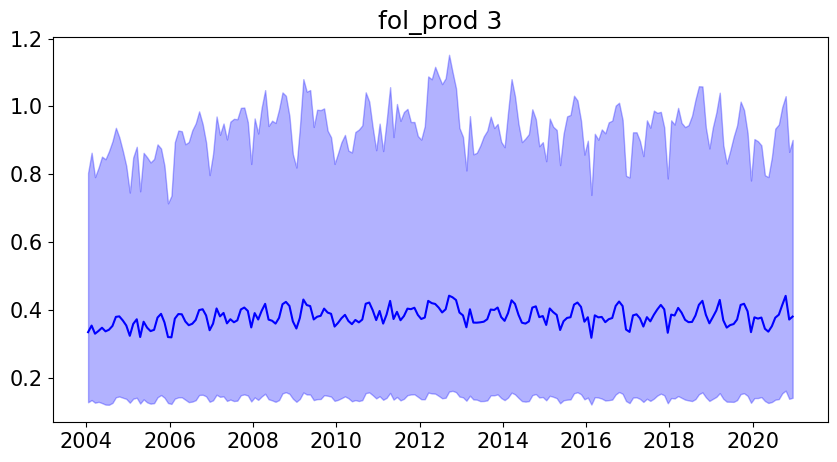

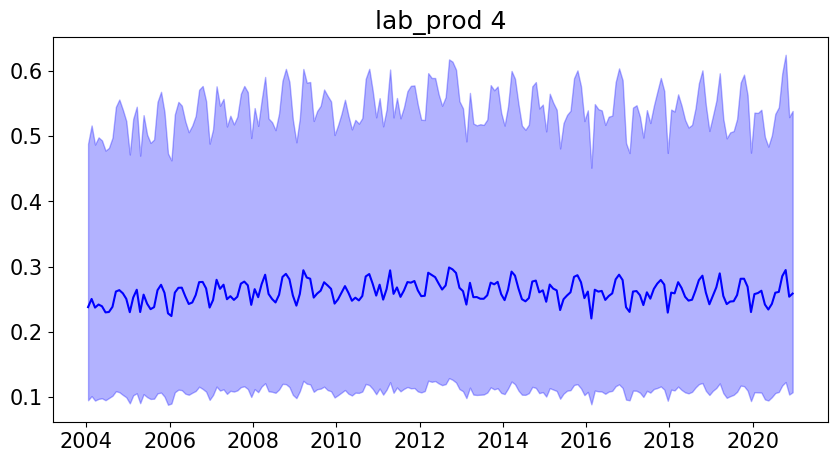

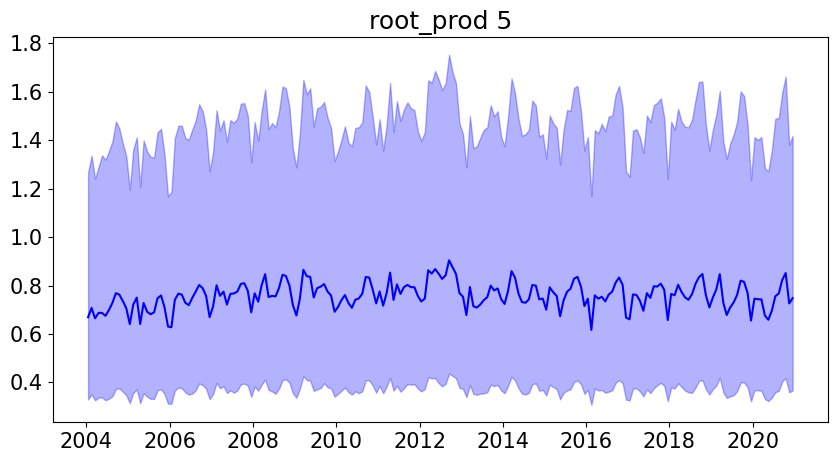

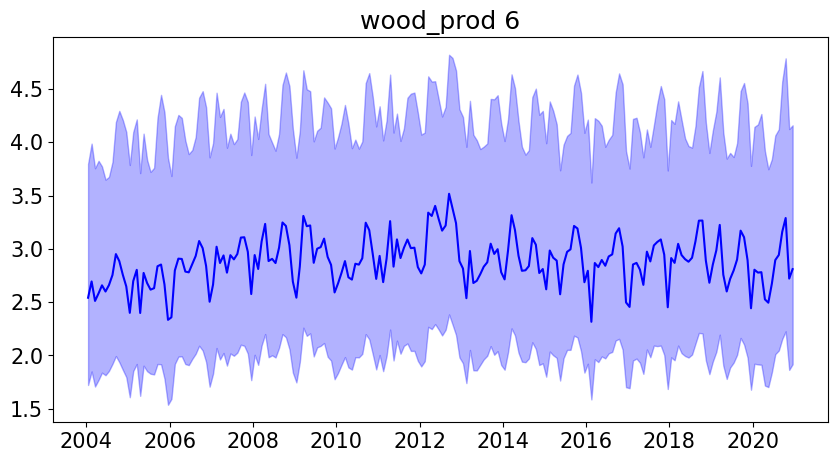

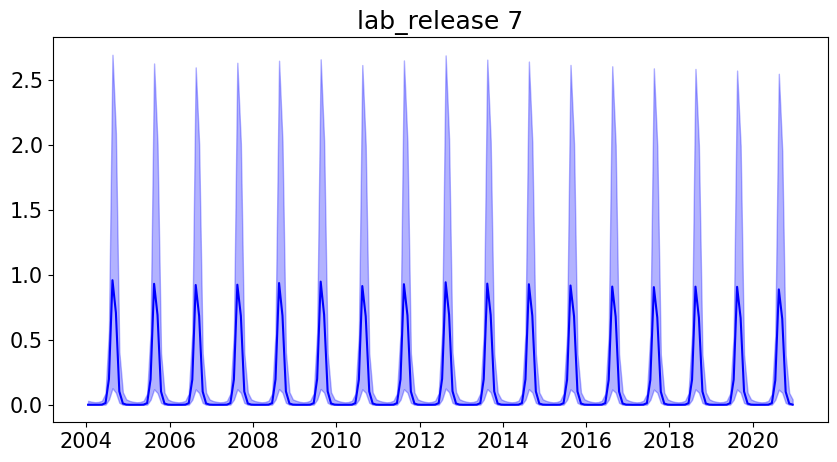

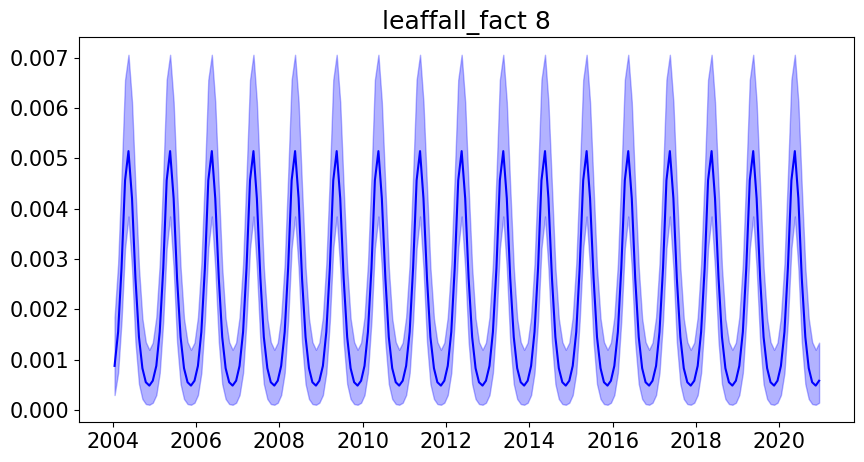

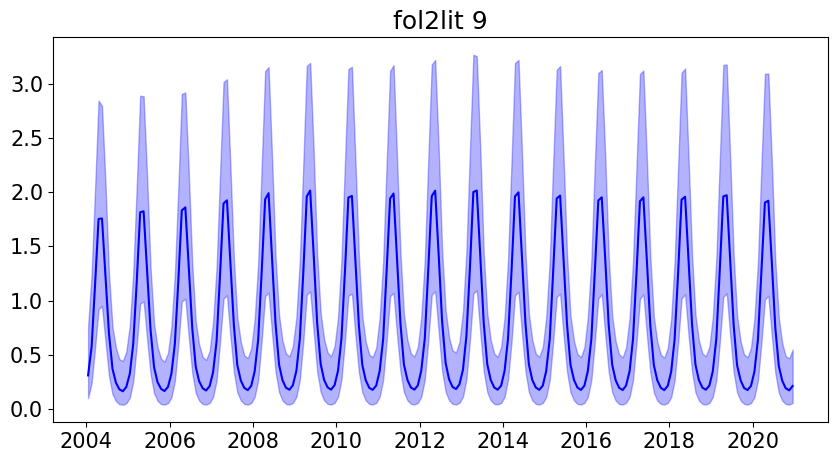

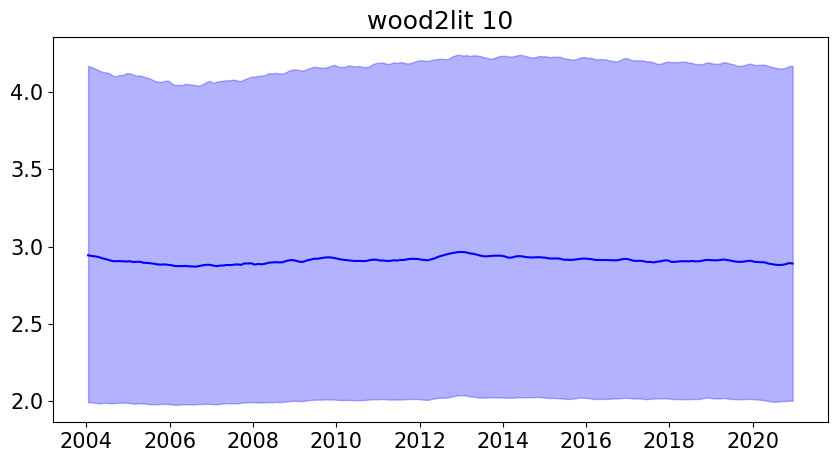

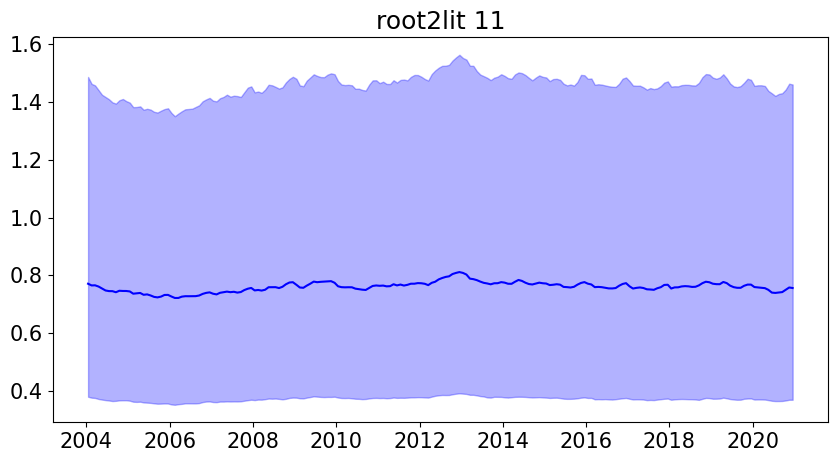

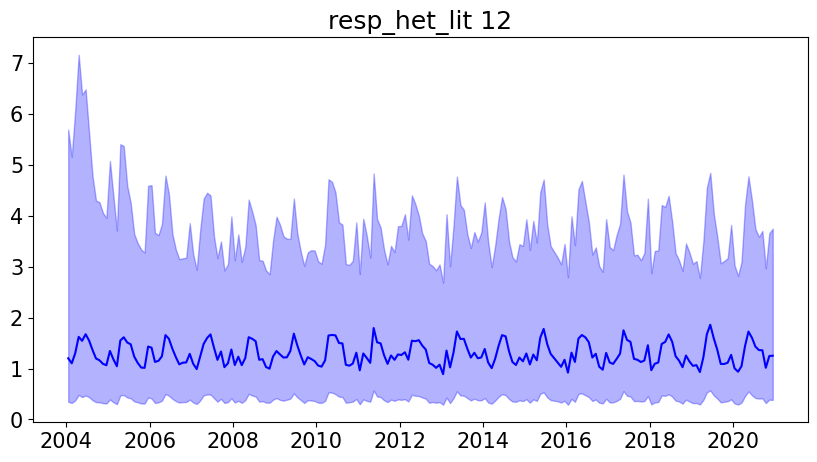

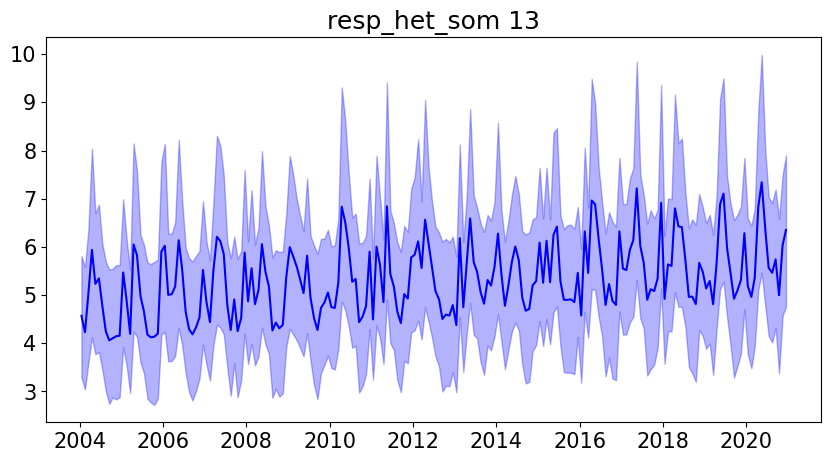

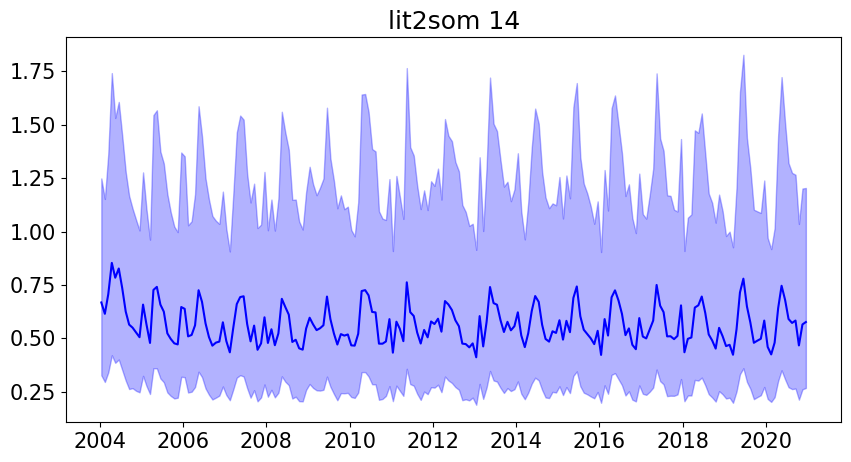

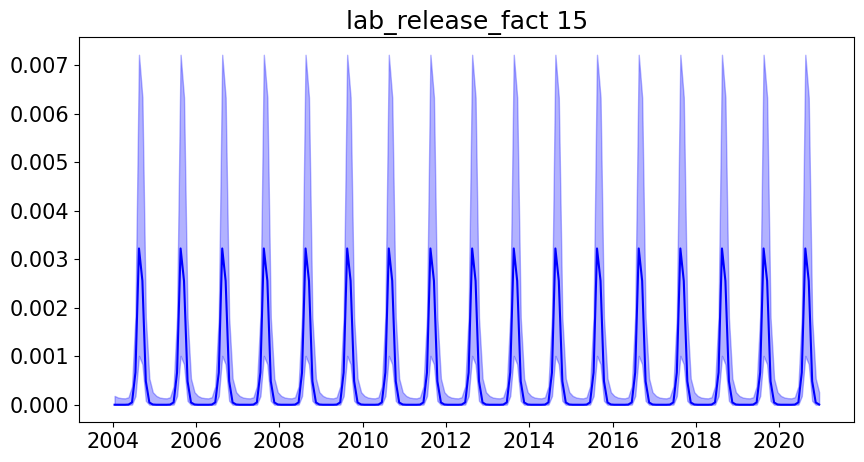

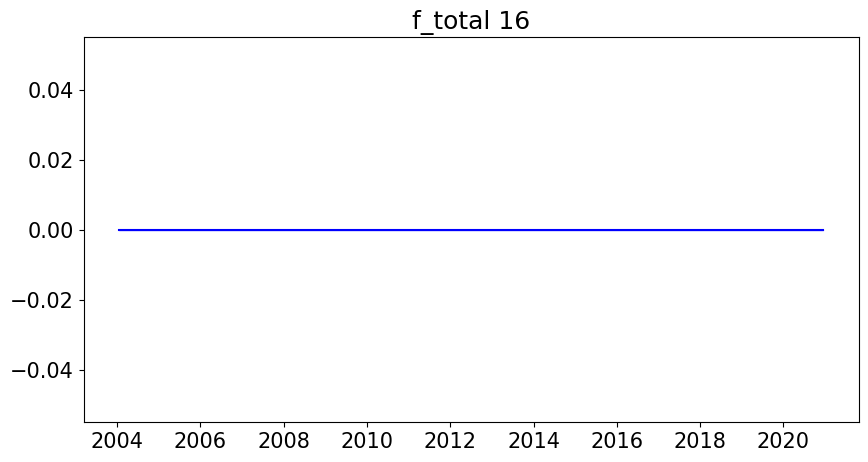

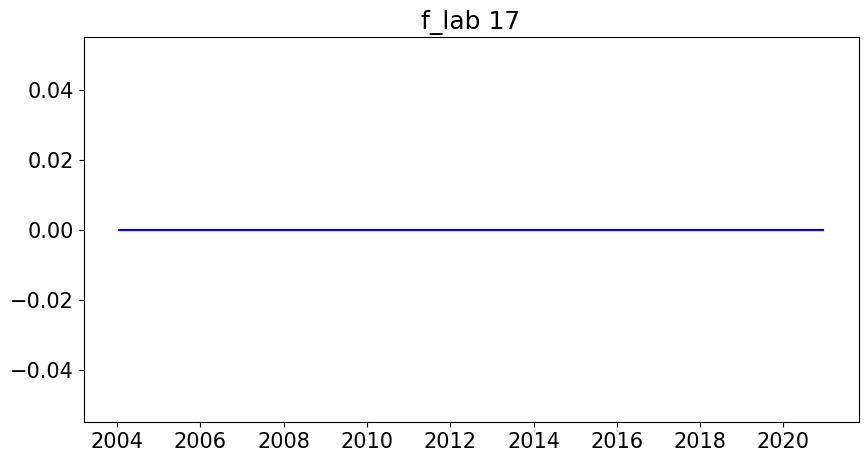

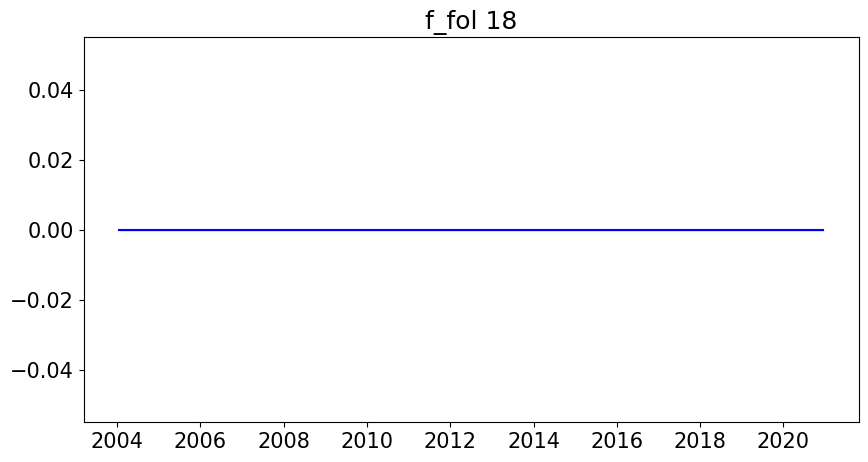

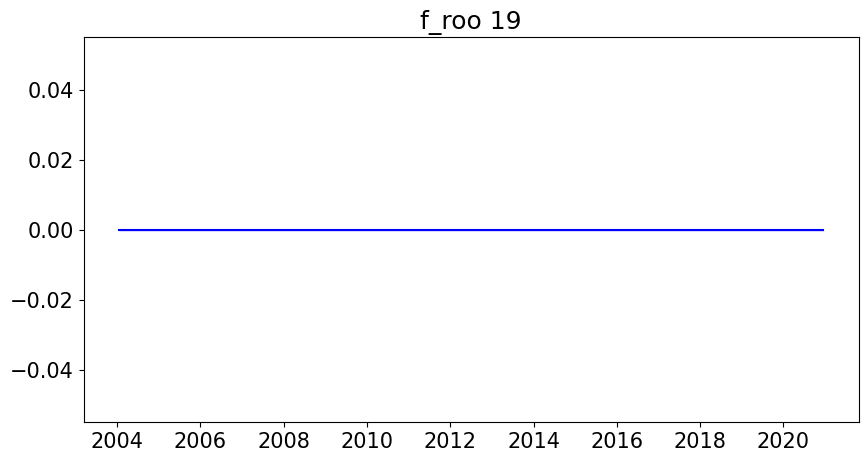

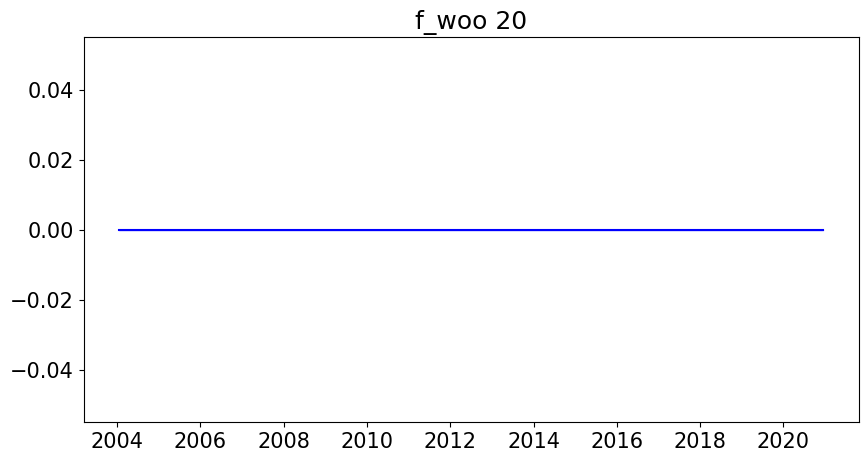

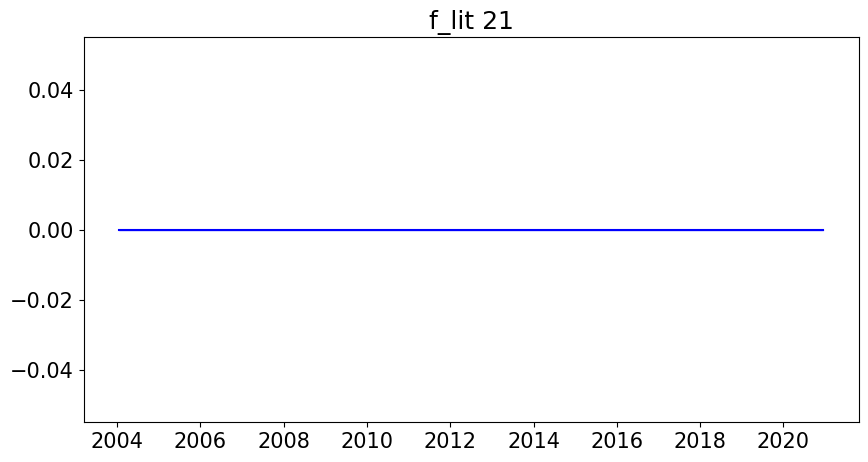

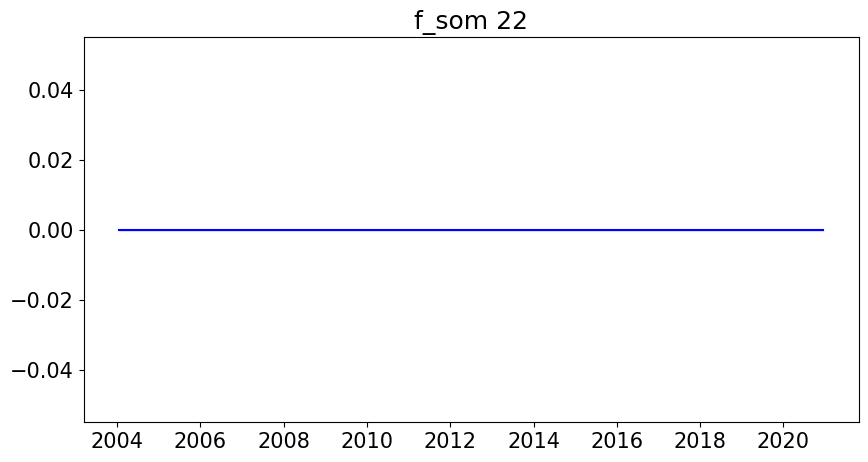

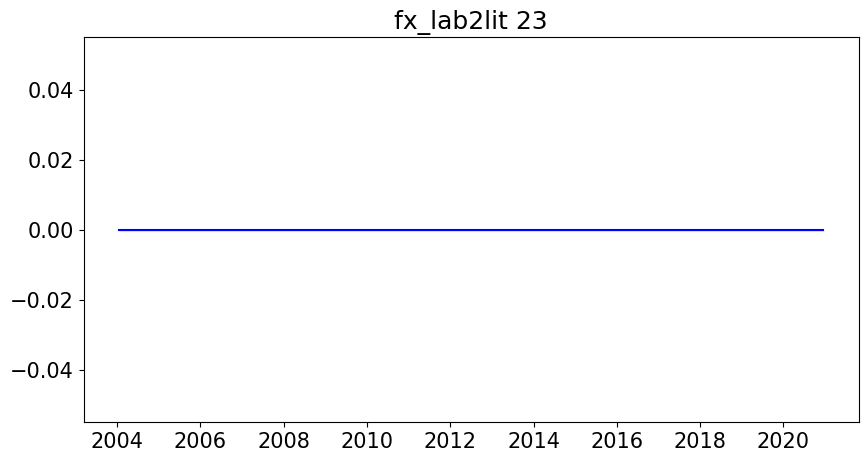

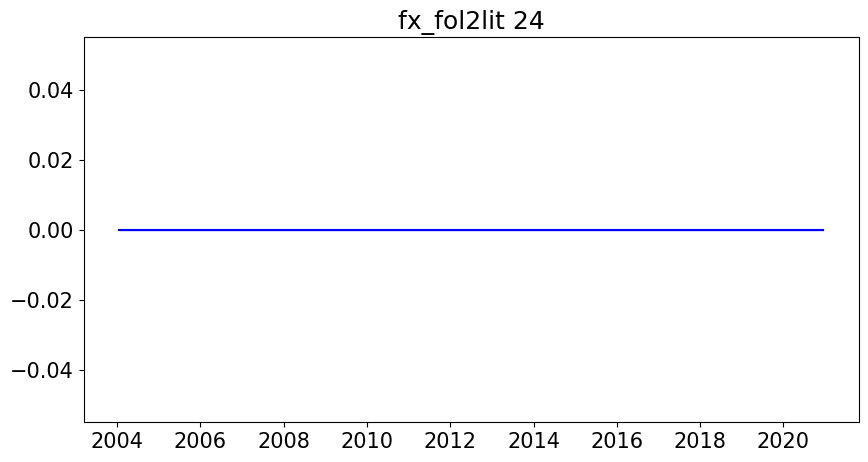

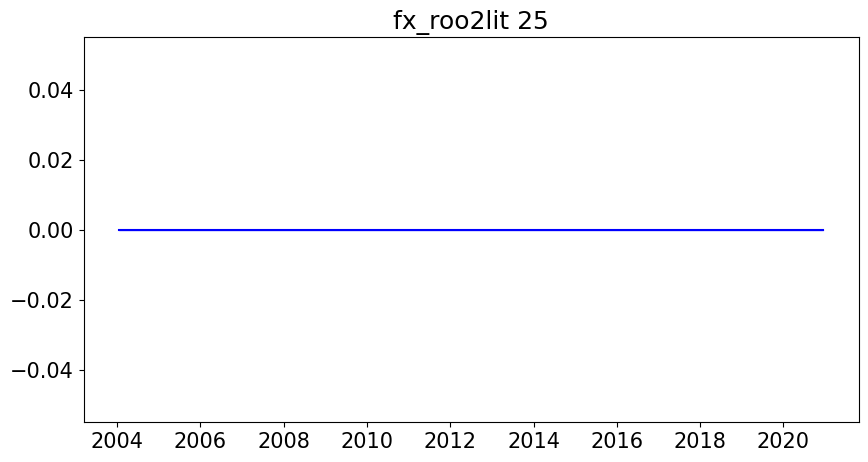

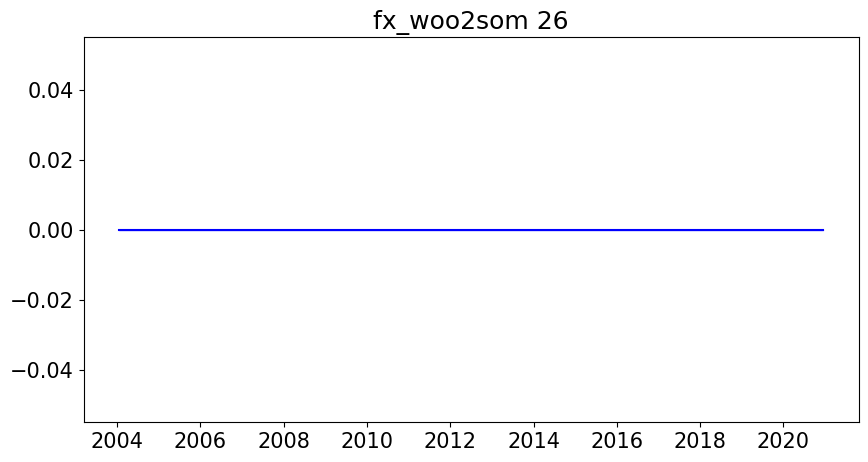

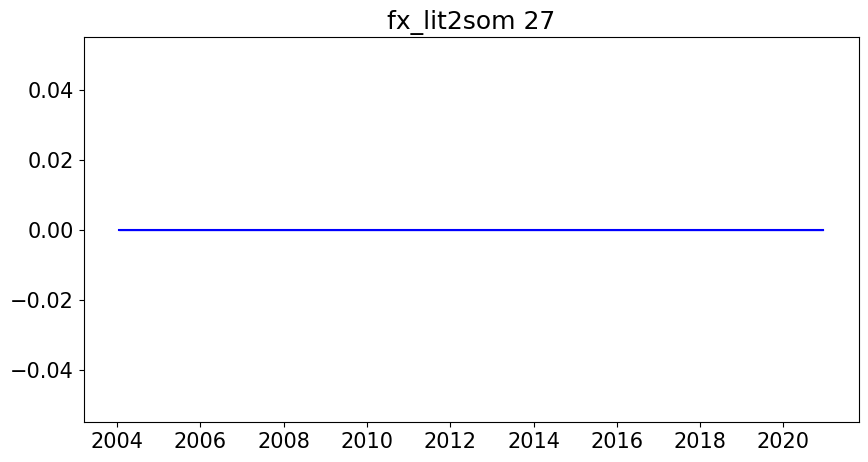

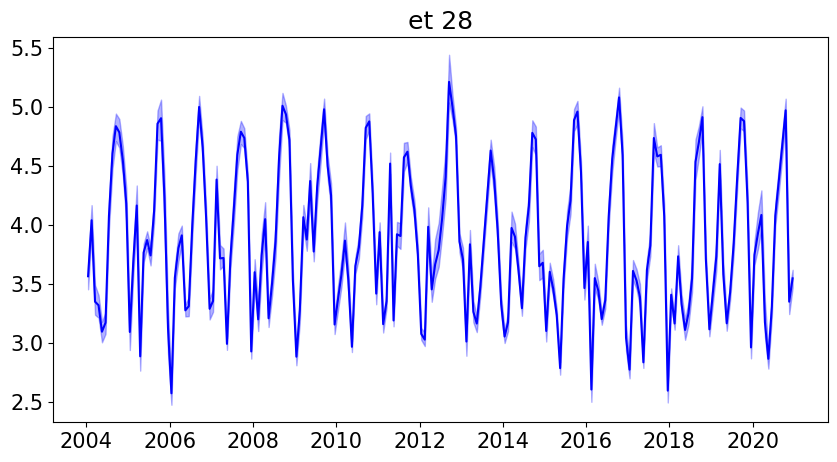

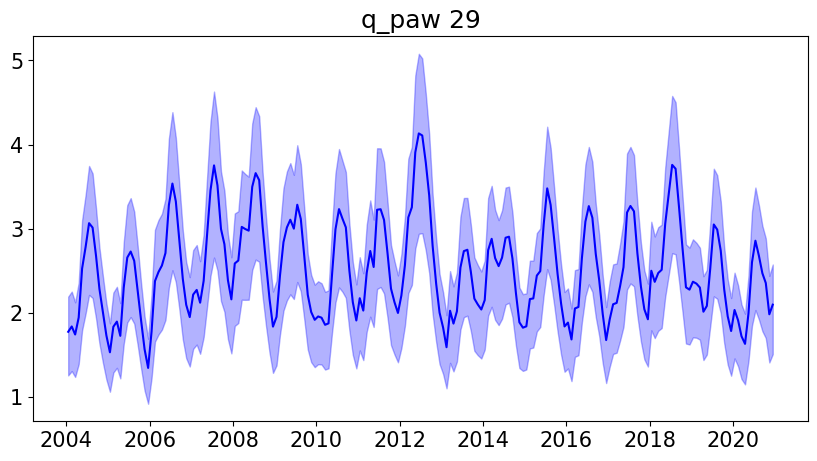

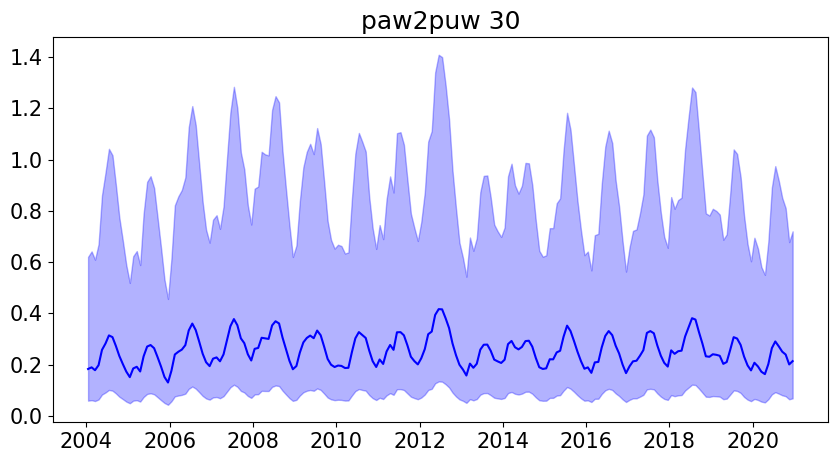

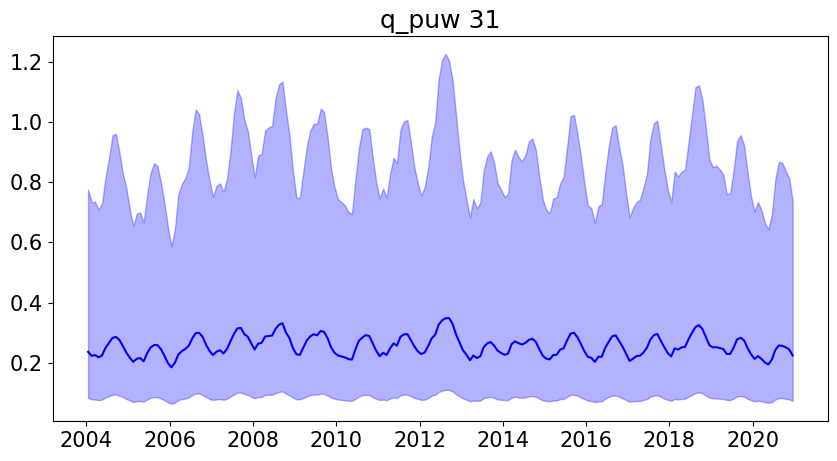

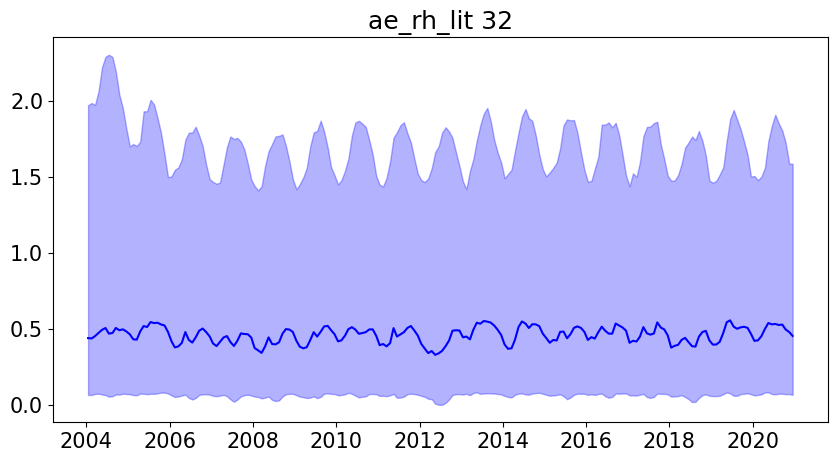

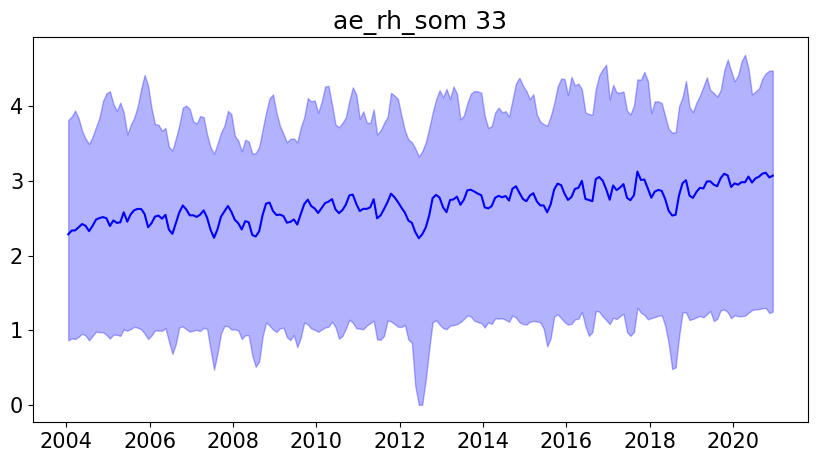

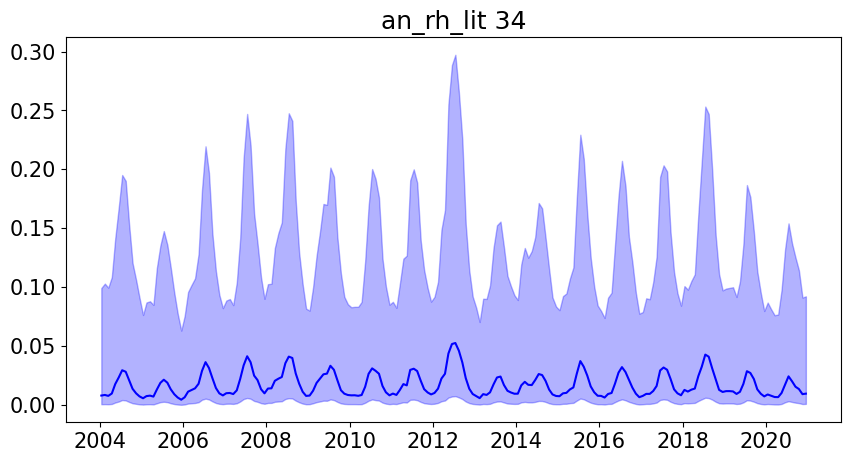

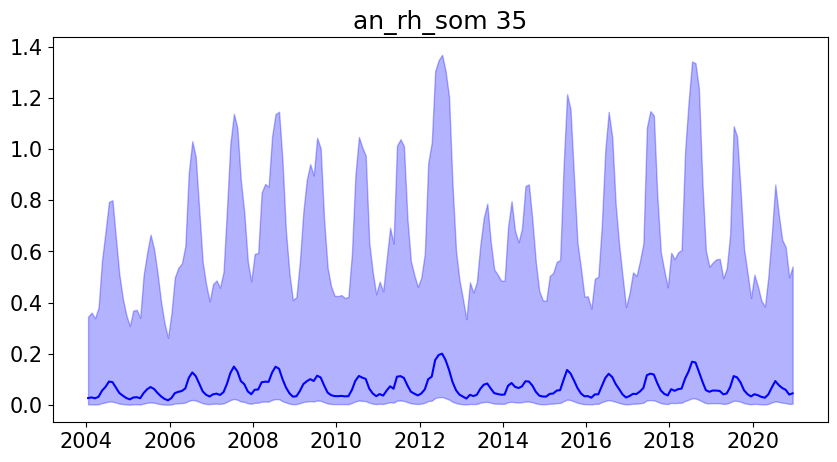

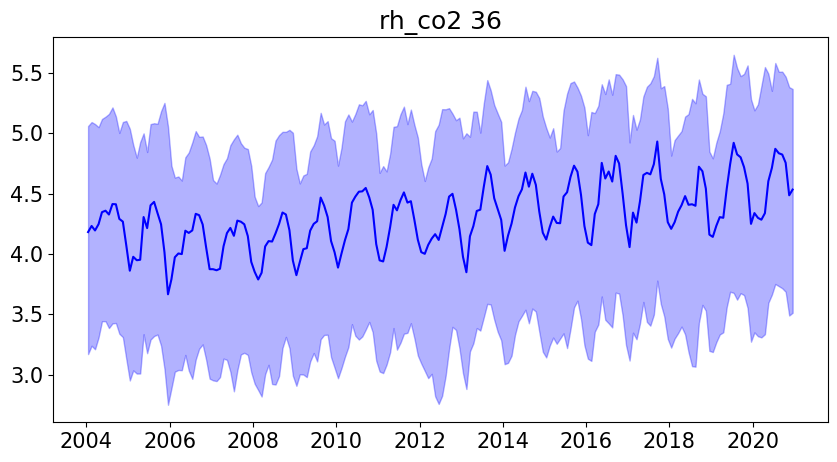

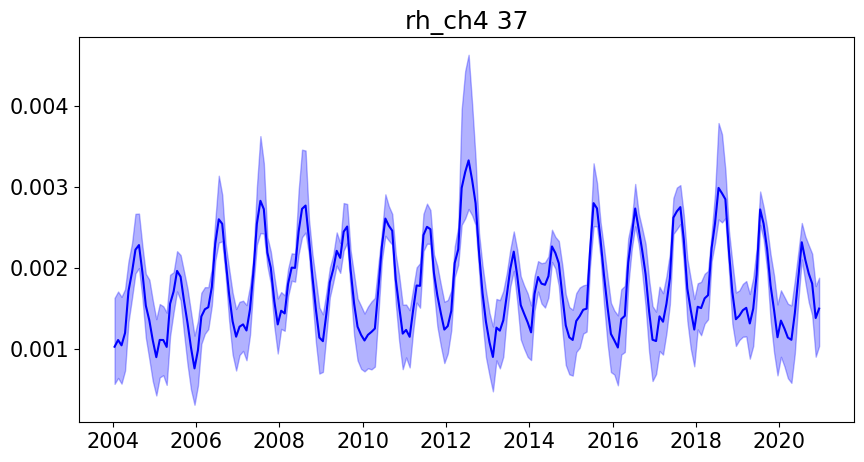

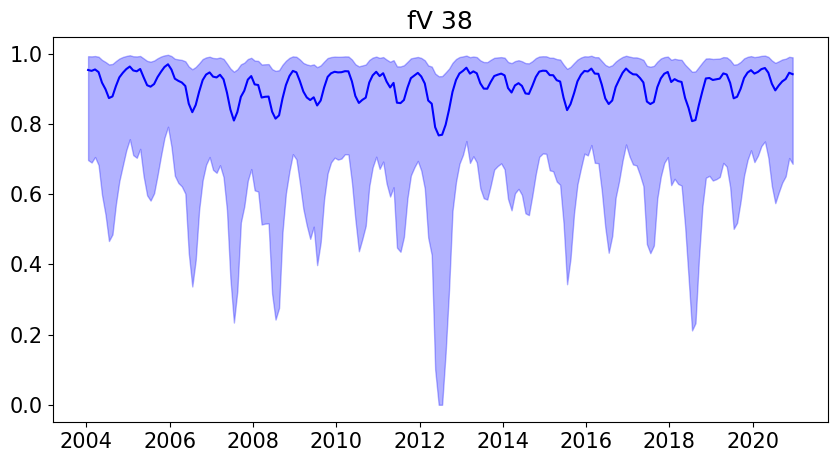

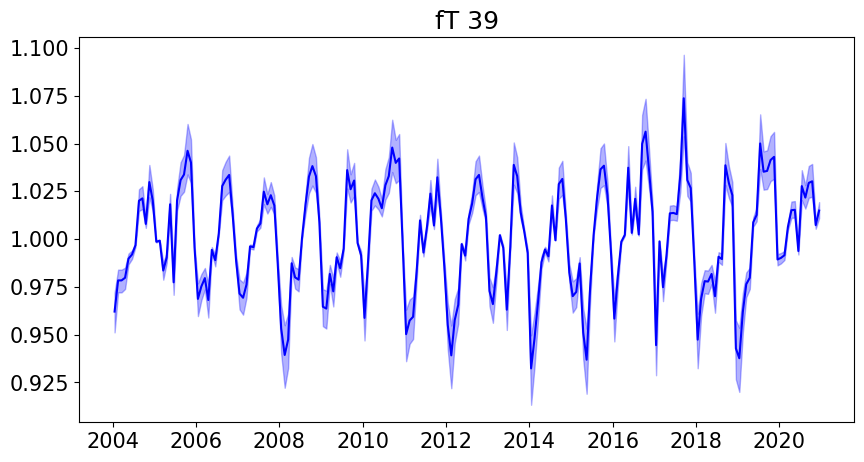

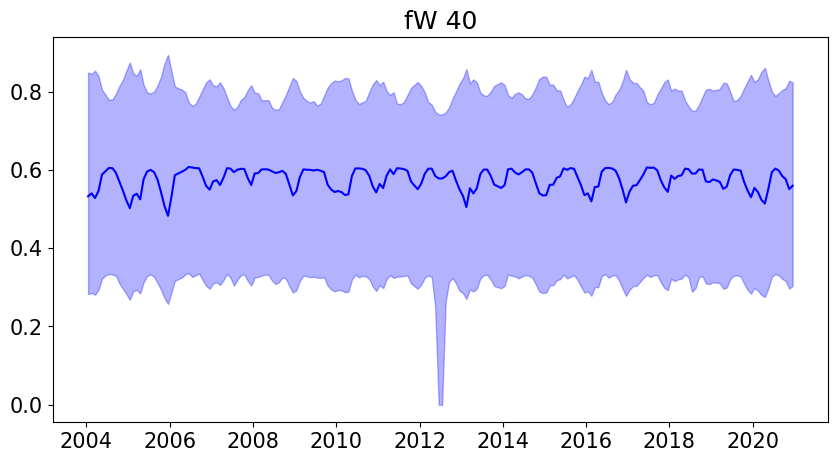

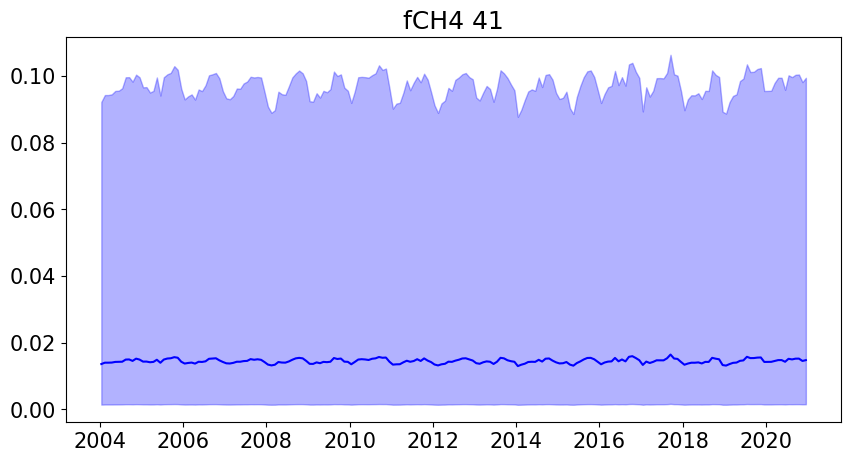

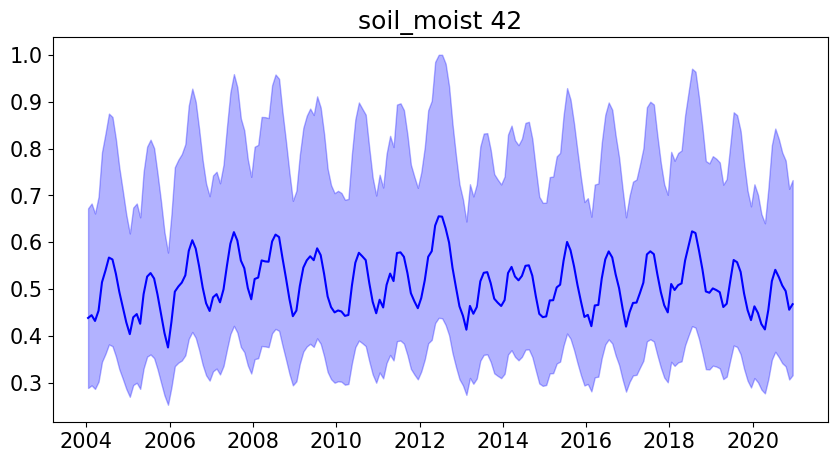

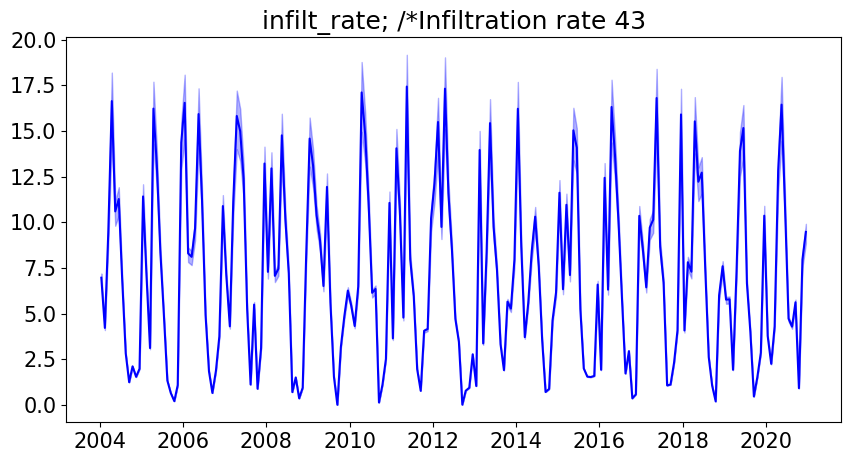

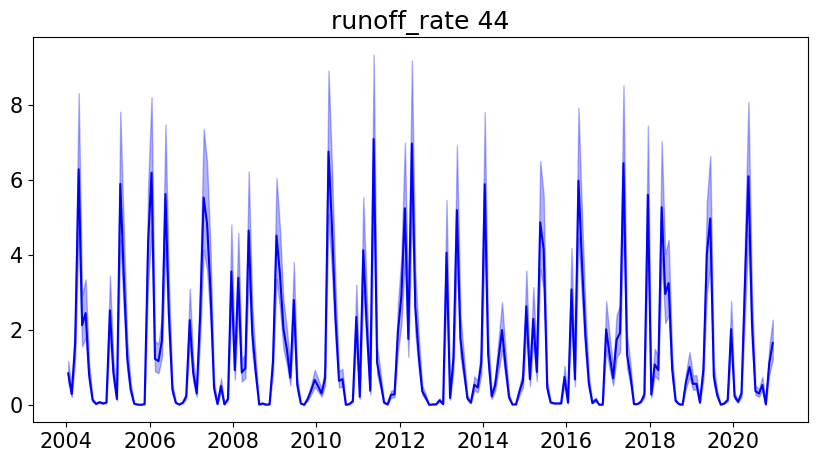

In [8]:
Fluxes = prt.get_flux(cbrfile+'.nc')
fluxinfo = prt.flux_info(c_loc,int(cbf["ID"][:]))

for a in fluxinfo.keys():
    plt.figure(figsize = (10,5))
    plt.title(fluxinfo[a] + " " + str(a))
    plt.plot(dates,np.median(Fluxes[:,:,a],axis = 0),color = 'blue')
    SDist = np.percentile(Fluxes[:,:,a],[25,75],axis = 0)
    plt.fill_between(dates, SDist[0,:], SDist[-1,:], color="blue", alpha=.3)

plt.show()


## Plot DAELC Pools from optimal paramaters

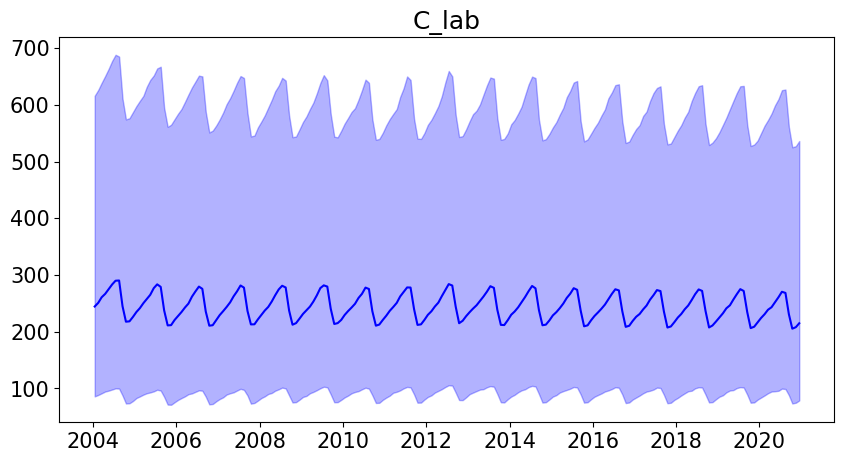

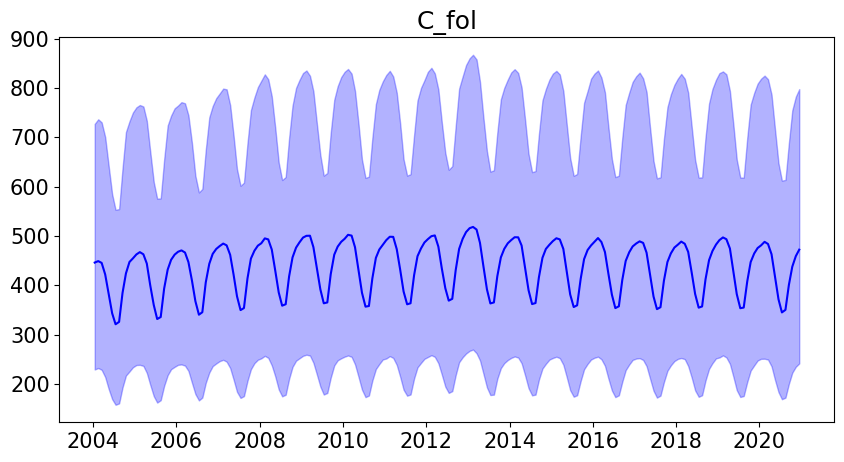

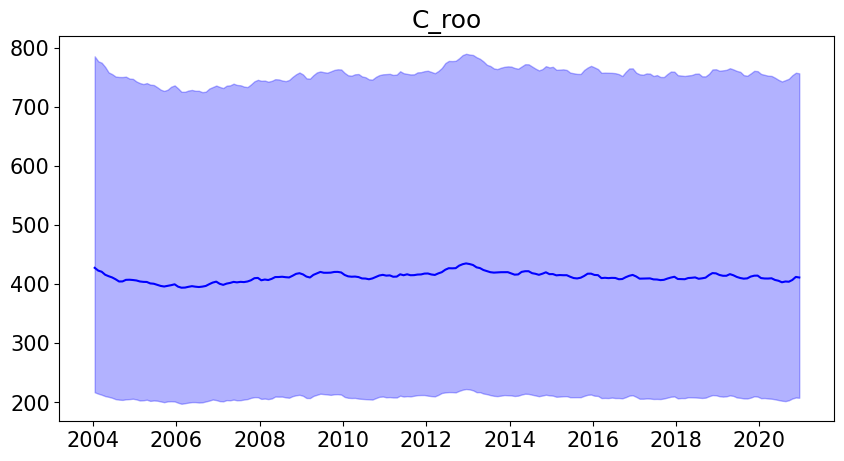

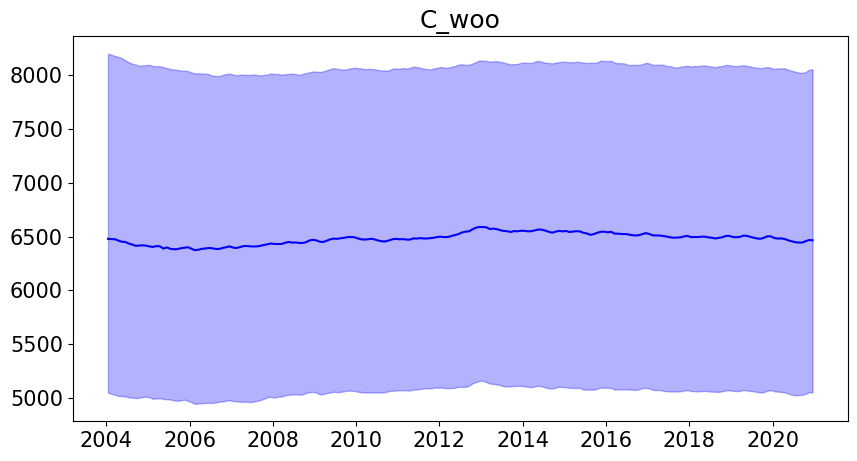

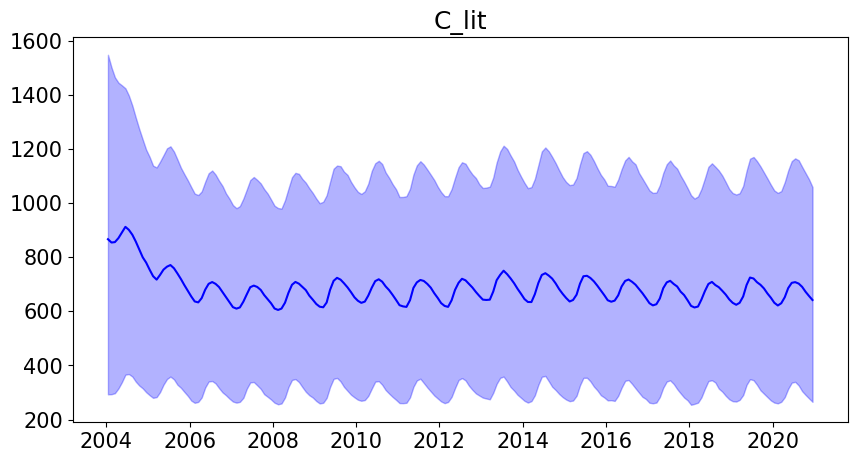

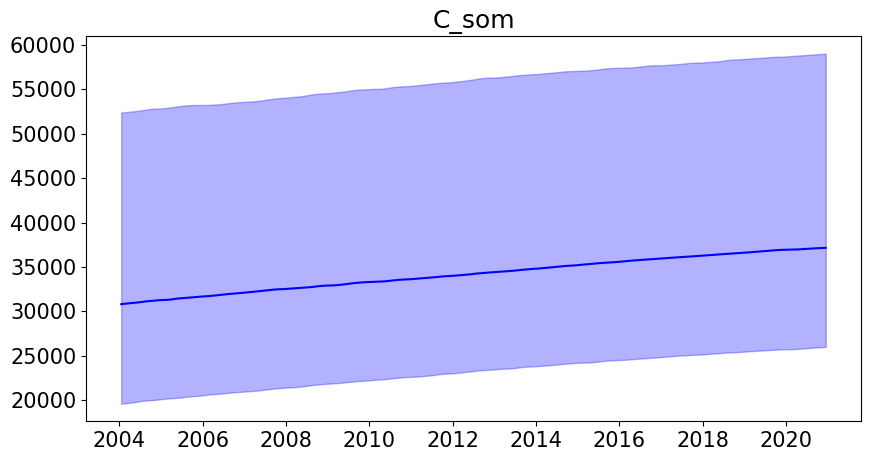

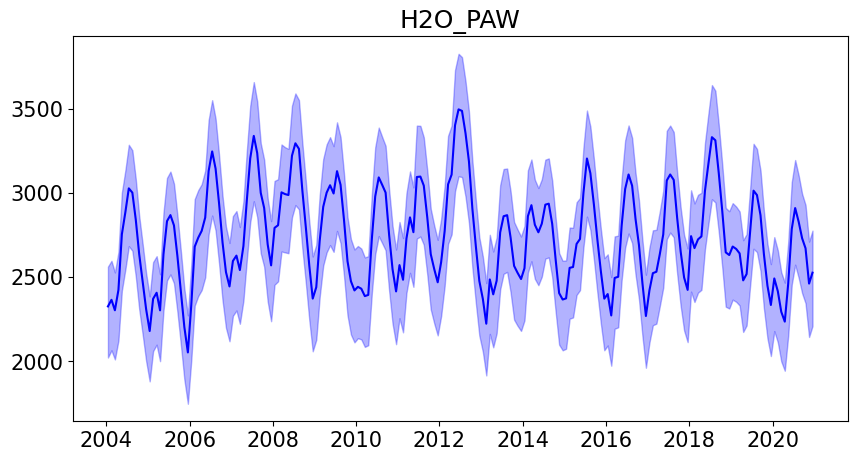

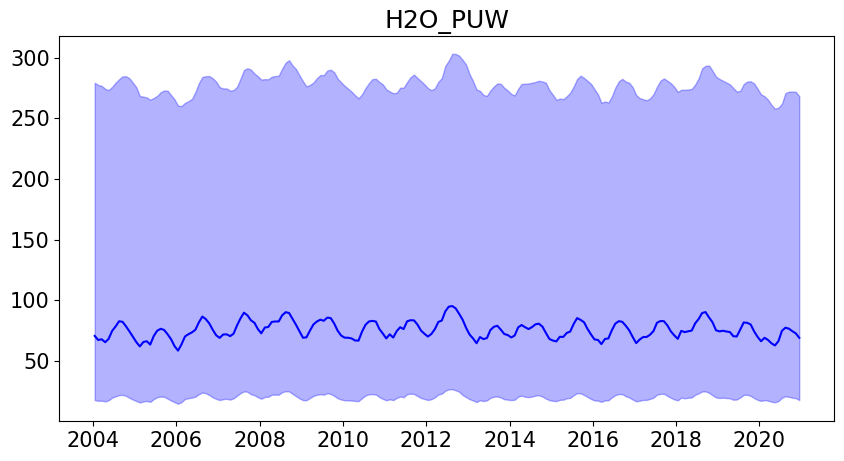

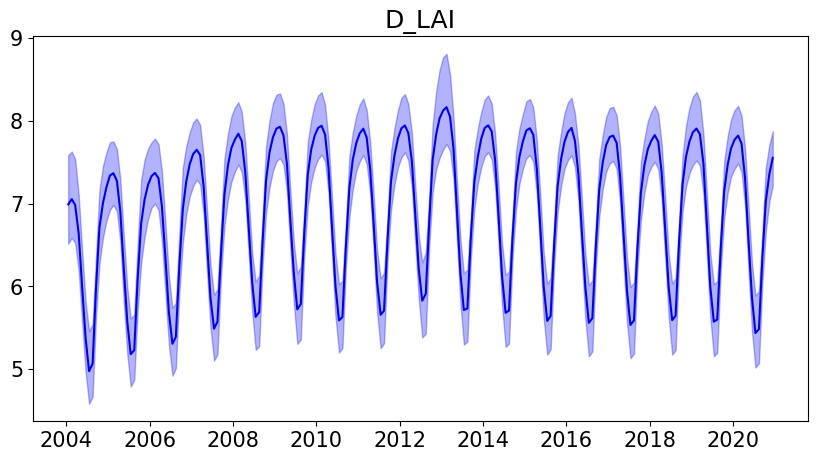

In [9]:
Pools = prt.get_pool(cbrfile+'.nc')
poolinfo = prt.pool_info(c_loc,int(cbf["ID"][:]))

for a in poolinfo.keys():
    plt.figure(figsize = (10,5))
    plt.title(poolinfo[a])
    plt.plot(dates,np.median(Pools[:,:,a],axis = 0)[0:-1],color = 'blue')
    SDist = np.percentile(Pools[:,:,a],[25,75],axis = 0)
    plt.fill_between(dates, SDist[0,0:-1], SDist[-1,0:-1], color="blue", alpha=.3)

plt.show()

In [14]:
cbf.close() #close the cbf file